In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
# Constants Variables
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


2025-01-24 01:46:03.714875: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-24 01:46:03.714904: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-01-24 01:46:03.714911: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-01-24 01:46:03.714926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-24 01:46:03.714935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Print the class names
class_names = dataset.class_names

# Get the class names
print("Dataset Classes:")
for i, class_name in enumerate(class_names):
    print(f"{i + 1}. {class_name.replace('_', ' ')}")

Dataset Classes:
1. Potato Early blight
2. Potato Late blight
3. Potato healthy


In [5]:
# Length of the dataset
dataset_length = len(dataset)
print(f"Dataset Length: {dataset_length}")

Dataset Length: 68


2025-01-24 01:46:04.003267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


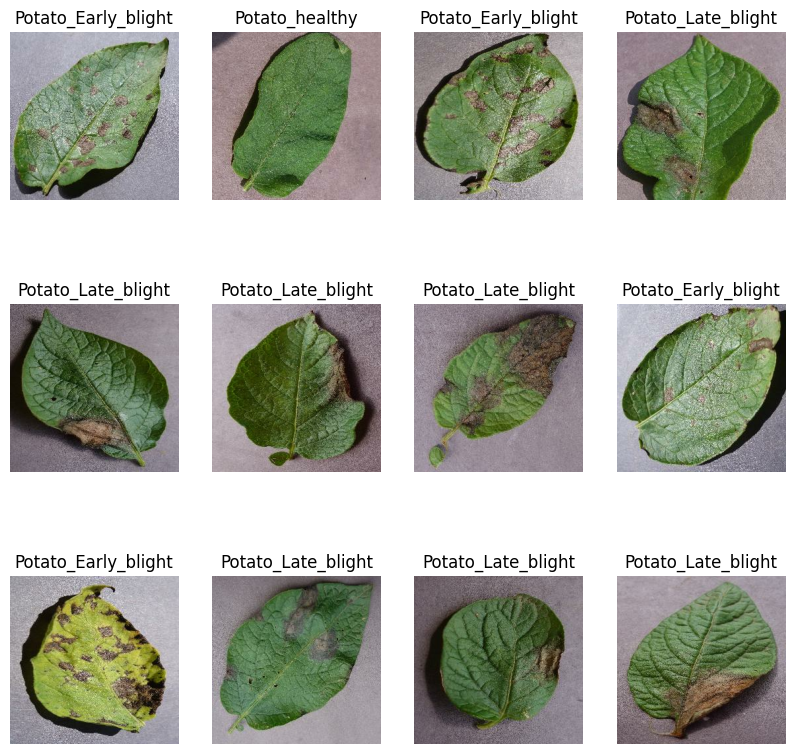

In [6]:
plt.figure(figsize=(10, 10))
for iamge_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(iamge_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# Train, Validation and Test Split
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Verify that split ratios sum to 1
    assert (train_split + test_split + val_split) == 1
    
    # Get the total size of the dataset
    ds_size = len(ds)
    
    # Shuffle the dataset if specified
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    # Calculate sizes for train and validation sets
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    # Split dataset into train, validation and test sets
    train_ds = ds.take(train_size)    # Take first train_size elements for training
    val_ds = ds.skip(train_size).take(val_size)    # Skip training data, take val_size elements for validation
    test_ds = ds.skip(train_size).skip(val_size)    # Skip training and validation data for test set
    
    return train_ds, val_ds, test_ds

In [8]:
# Get the partitions
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Print the length of the datasets
print("Train Dataset: ", len(train_ds))
print("Validation Dataset: ", len(val_ds))
print("Test Dataset: ", len(test_ds))

Train Dataset:  54
Validation Dataset:  6
Test Dataset:  8


In [9]:
# Train DS Cache, Prefetch and Shuffle
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Validation DS Cache, Prefetch and Shuffle
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Test DS Cache, Prefetch and Shuffle
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
# Resize and Rescale the images using Sequential API
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [11]:
# Data Augmentation using Sequential API
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [12]:
# Nural Network Architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Create the model using Sequential API
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/opt/anaconda3/envs/metal-env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
# Train the model using fit
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
)

Epoch 1/50


/opt/anaconda3/envs/metal-env/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-01-24 01:46:04.846813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.4499 - loss: 0.9878 - val_accuracy: 0.4531 - val_loss: 1.0033
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4649 - loss: 0.9312 - val_accuracy: 0.4531 - val_loss: 0.9365
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4844 - loss: 0.8402 - val_accuracy: 0.7812 - val_loss: 0.4556
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8505 - loss: 0.3640 - val_accuracy: 0.5208 - val_loss: 0.9650
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8070 - loss: 0.4483 - val_accuracy: 0.9271 - val_loss: 0.2012
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9627 - loss: 0.0895 - val_accuracy: 0.9635 - val_loss: 0.1001
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9564 - loss: 0.1032 - val_accuracy: 0.9271 - val_loss: 0.3237
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9615 - loss: 0.1063 - val_accuracy: 0.9740 - val_loss: 0.

In [16]:
# Print the Score
score = model.evaluate(test_ds)

# Print the History
print("History: ", history.history)

# Print the History Parameters
print("History Parameters: ", history.params)

# Print the History Keys
print("History Keys: ", history.history.keys())

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9965 - loss: 0.0065   
History:  {'accuracy': [0.46469905972480774, 0.48495370149612427, 0.5758101940155029, 0.8709490895271301, 0.8854166865348816, 0.9594907164573669, 0.9496527910232544, 0.9606481194496155, 0.9797453880310059, 0.9756944179534912, 0.9375, 0.9519675970077515, 0.9872685074806213, 0.9895833134651184, 0.9739583134651184, 0.9837962985038757, 0.9907407164573669, 0.9930555820465088, 0.9814814925193787, 0.9936342835426331, 0.9745370149612427, 0.9739583134651184, 0.9884259104728699, 0.9918981194496155, 0.9971064925193787, 0.9918981194496155, 0.9872685074806213, 0.9901620149612427, 0.9583333134651184, 0.9895833134651184, 0.9988425970077515, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.9880185723304749, 0.911980152130127, 0.7650890350341797, 0.355781614780426, 0.2868167459964752, 0.10554543137550354, 0.13506925106048584, 0.11020325124263763, 0.058366116136312485, 0.0

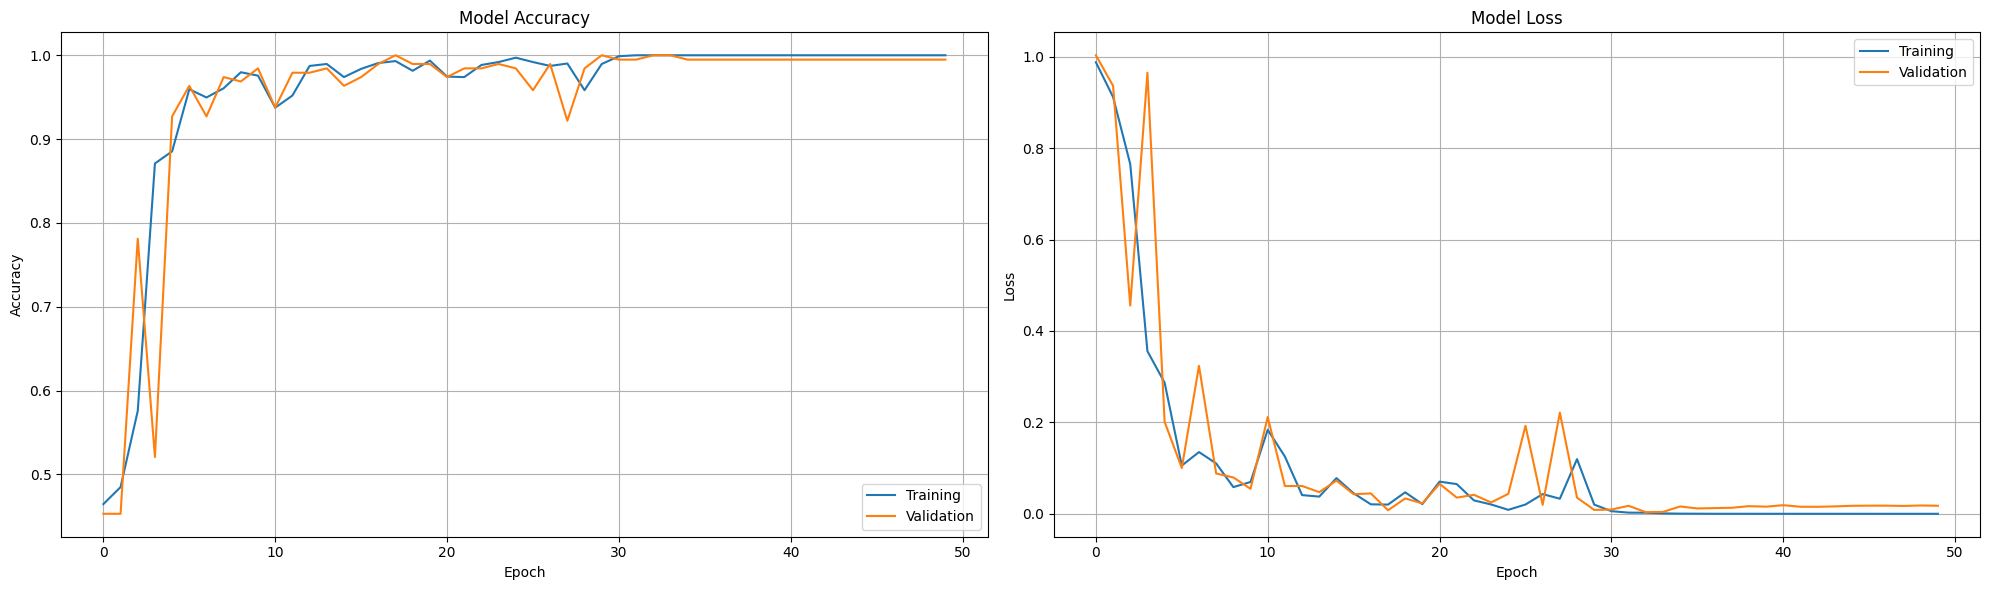

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure and axis objects with a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


2025-01-24 01:49:20.087227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


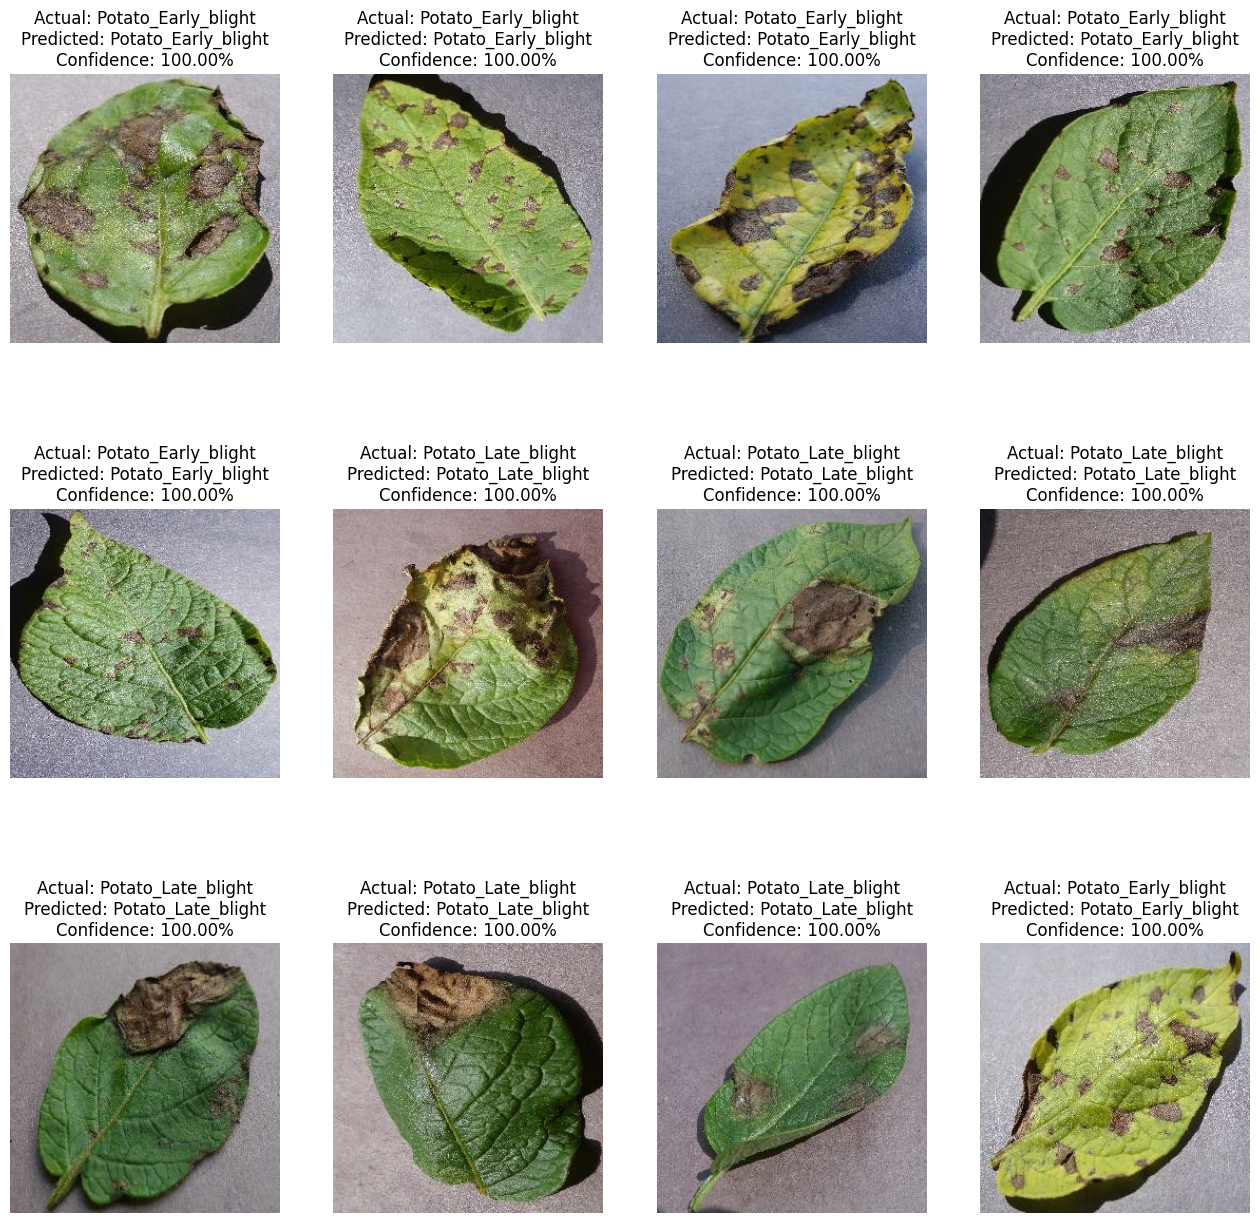

In [18]:
# Predictions using the model
for image_batch, labels_batch in test_ds.take(1):  # Take one batch from test dataset
    ps = model.predict(image_batch)  # Get model predictions for the batch
    images = image_batch.numpy().astype("uint8")  # Convert images to numpy array
    labels = labels_batch.numpy()  # Convert labels to numpy array

    plt.figure(figsize=(16, 16))  # Create a figure with specified size
    for i in range(12):  # Loop through first 12 images
        ax = plt.subplot(3, 4, i + 1)  # Create a 3x4 subplot grid
        plt.imshow(images[i])  # Display the image
        
        # Get prediction confidence
        confidence = ps[i][ps[i].argmax()] * 100
        
        # Create title with actual label, predicted label and confidence
        title = f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[ps[i].argmax()]}\nConfidence: {confidence:.2f}%"
        plt.title(title)  # Show title
        plt.axis("off")  # Hide axes

In [21]:
# Save the model
model_version = "V0.1"
model_name = "PlantDiseaseDetection"
model.save(f"./models/{model_name}_{model_version}.keras")
